In [3]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
#import scvelo as scv
import pandas as pd
import seaborn as sns
import scanpy as sc

In [5]:
adata = sc.read('hsc.h5ad')
adata

AnnData object with n_obs × n_vars = 1947 × 21418
    obs: 'batch', 'cell_type', 'time', 'nGenes'
    var: 'gene_name_mapping'
    obsm: 'X_umap'
    layers: 'new', 'spliced', 'total', 'unspliced', 'velocity_alpha_minus_gamma_s'

In [6]:
#scv.pp.filter_genes(adata, min_shared_counts=20)
sc.pp.normalize_per_cell(adata)
sc.pp.filter_genes_dispersion(adata, n_top_genes=2000)
sc.pp.log1p(adata)

C:\Users\user\AppData\Local\Temp\ipykernel_10656\3751388722.py:2: FutureWarning: Use sc.pp.normalize_total instead
  sc.pp.normalize_per_cell(adata)
c:\Users\user\OneDrive\Desktop\Bio\venv\Lib\site-packages\scanpy\preprocessing\_simple.py:589: FutureWarning: Use sc.pp.normalize_total instead
  normalize_per_cell(
C:\Users\user\AppData\Local\Temp\ipykernel_10656\3751388722.py:3: FutureWarning: Use sc.pp.highly_variable_genes instead
  sc.pp.filter_genes_dispersion(adata, n_top_genes=2000)
c:\Users\user\OneDrive\Desktop\Bio\venv\Lib\site-packages\scanpy\preprocessing\_deprecated\highly_variable_genes.py:140: FutureWarning: Use sc.pp.highly_variable_genes instead
  result = filter_genes_dispersion(
c:\Users\user\OneDrive\Desktop\Bio\venv\Lib\site-packages\scanpy\preprocessing\_deprecated\highly_variable_genes.py:131: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)


In [7]:
X = np.asarray(adata.X.todense())
Y = np.asarray(adata.layers['velocity_alpha_minus_gamma_s'].todense())
Y[np.isnan(Y)] = 0
idx_velocity = np.where(abs(Y).sum(0) > 10)[0]
Y = Y[:,idx_velocity]
X.shape, Y.shape

((1947, 1999), (1947, 281))

In [8]:
idx_test = np.random.choice(X.shape[0],100,replace=False)
idx_train = np.setdiff1d(np.arange(X.shape[0]),idx_test)
X_train, Y_train = X[idx_train], Y[idx_train]
X_test, Y_test = X[idx_test], Y[idx_test]

In [9]:
regr = RandomForestRegressor(min_samples_split=5,max_features=0.05,oob_score=True)
scores = []
for i in range(10, 100+1, 10):
    regr.set_params(n_estimators=i)
    regr.fit(X_train,Y_train)
    scores.append((i,'OOB score',regr.oob_score_))
    scores.append((i,'Test score',regr.score(X_test,Y_test)))
    print(i)

c:\Users\user\OneDrive\Desktop\Bio\venv\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


10
20
30
40
50
60
70
80
90
100


<Axes: xlabel='Number of trees', ylabel='R^2'>

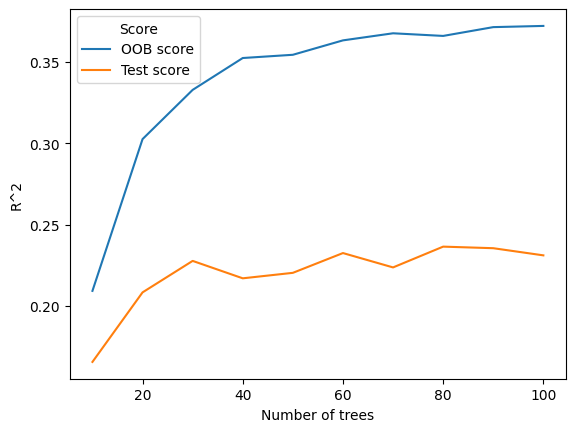

In [10]:
scores = pd.DataFrame(scores,columns=['Number of trees','Score','R^2'])
sns.lineplot(scores,x='Number of trees',y='R^2',hue='Score')

<Axes: >

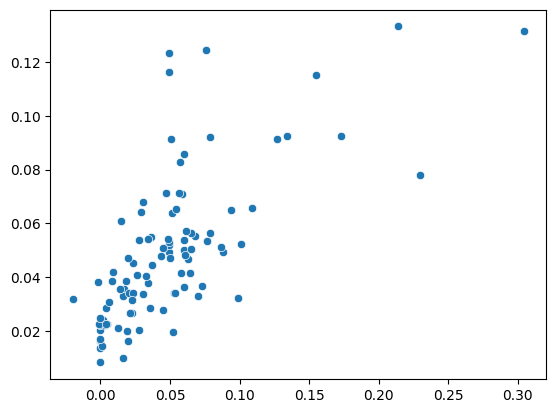

In [11]:
V = regr.predict(X_test)
sns.scatterplot(x=Y_test[:,1], y=V[:,1])